In [151]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
import joblib
import os

In [152]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to C:\Users\DELL/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\DELL/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DELL/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\DELL/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [153]:
df = pd.read_csv("./data/spam.csv", encoding = "latin1")

In [154]:
df = df[["v2", "v1"]]

In [155]:
df.rename(columns = {"v2": "message", "v1": "label"}, inplace = True)

In [156]:
df["label"] = df["label"].replace({"ham": 0, "spam": 1})

C:\Users\DELL\AppData\Local\Temp\ipykernel_7120\254151828.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["label"] = df["label"].replace({"ham": 0, "spam": 1})


In [157]:
df

,message,label
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0
...,...,...
5567,This is the 2nd time we have tried 2 contact u...,1
5568,Will ï¿½_ b going to esplanade fr home?,0
5569,"Pity, * was in mood for that. So...any other s...",0
5570,The guy did some bitching but I acted like i'd...,0


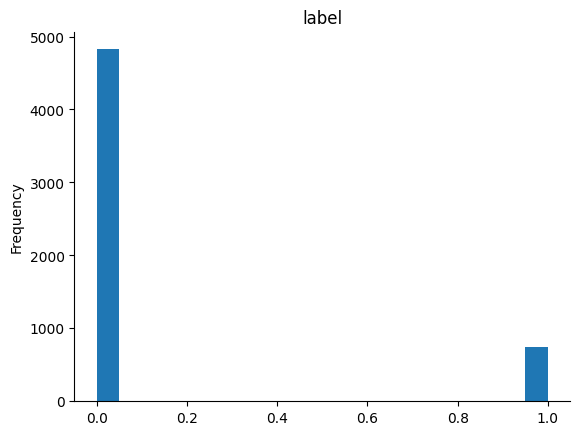

In [158]:
# @title label

from matplotlib import pyplot as plt
df['label'].plot(kind='hist', bins=20, title='label')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [159]:
def clean_text(text):
    text = re.sub(r"(?<=\d)\.(?=\d)", "", text)
    text = re.sub(r"(?<=\w)\\'(?=\w)", "", text)
    text = re.sub(r"(?<=\w)\'(?=\w)", "", text)
    text = re.sub(r"&lt;#&gt;", "", text)
    text = re.sub(r"[^a-zA-Z0-9\s]", " ", text)
    text = re.sub(r"\s+", " ", text)
    text = text.lower()
    return text.strip()

In [160]:
df["cleaned_message"] = df["message"].apply(clean_text)

In [161]:
def preprocess_text(text):
    text = " ".join([WordNetLemmatizer().lemmatize(token) for token in word_tokenize(text) if token not in set(stopwords.words("english"))])
    return text.strip()

In [162]:
df

,message,label,cleaned_message
0,"Go until jurong point, crazy.. Available only ...",0,go until jurong point crazy available only in ...
1,Ok lar... Joking wif u oni...,0,ok lar joking wif u oni
2,Free entry in 2 a wkly comp to win FA Cup fina...,1,free entry in 2 a wkly comp to win fa cup fina...
3,U dun say so early hor... U c already then say...,0,u dun say so early hor u c already then say
4,"Nah I don't think he goes to usf, he lives aro...",0,nah i dont think he goes to usf he lives aroun...
...,...,...,...
5567,This is the 2nd time we have tried 2 contact u...,1,this is the 2nd time we have tried 2 contact u...
5568,Will ï¿½_ b going to esplanade fr home?,0,will b going to esplanade fr home
5569,"Pity, * was in mood for that. So...any other s...",0,pity was in mood for that so any other suggest...
5570,The guy did some bitching but I acted like i'd...,0,the guy did some bitching but i acted like id ...


In [163]:
df["preprocessed_message"] = df["cleaned_message"].apply(preprocess_text)

In [164]:
df = df.drop_duplicates()

In [165]:
df = df[~(df["preprocessed_message"].str.len() == 0)]

In [166]:
df = df[~(df["preprocessed_message"].str.split().apply(len) <= 1)]

In [167]:
df

,message,label,cleaned_message,preprocessed_message
0,"Go until jurong point, crazy.. Available only ...",0,go until jurong point crazy available only in ...,go jurong point crazy available bugis n great ...
1,Ok lar... Joking wif u oni...,0,ok lar joking wif u oni,ok lar joking wif u oni
2,Free entry in 2 a wkly comp to win FA Cup fina...,1,free entry in 2 a wkly comp to win fa cup fina...,free entry 2 wkly comp win fa cup final tkts 2...
3,U dun say so early hor... U c already then say...,0,u dun say so early hor u c already then say,u dun say early hor u c already say
4,"Nah I don't think he goes to usf, he lives aro...",0,nah i dont think he goes to usf he lives aroun...,nah dont think go usf life around though
...,...,...,...,...
5567,This is the 2nd time we have tried 2 contact u...,1,this is the 2nd time we have tried 2 contact u...,2nd time tried 2 contact u u 750 pound prize 2...
5568,Will ï¿½_ b going to esplanade fr home?,0,will b going to esplanade fr home,b going esplanade fr home
5569,"Pity, * was in mood for that. So...any other s...",0,pity was in mood for that so any other suggest...,pity mood suggestion
5570,The guy did some bitching but I acted like i'd...,0,the guy did some bitching but i acted like id ...,guy bitching acted like id interested buying s...


In [168]:
for i in range(1490, 1501):
    print(df.iloc[i]["message"])
    print(df.iloc[i]["cleaned_message"])
    print(df.iloc[i]["preprocessed_message"])
    print()

Dude just saw a parked car with its sunroof popped up. Sux
dude just saw a parked car with its sunroof popped up sux
dude saw parked car sunroof popped sux

Get ready to put on your excellent sub face :)
get ready to put on your excellent sub face
get ready put excellent sub face

Tmrw. Im finishing 9 doors
tmrw im finishing 9 doors
tmrw im finishing 9 door

The  &lt;#&gt; g that i saw a few days ago, the guy wants sell wifi only for  &lt;#&gt;  and with 3g for  &lt;#&gt; . That's why i blanked him.
the g that i saw a few days ago the guy wants sell wifi only for and with 3g for thats why i blanked him
g saw day ago guy want sell wifi 3g thats blanked

whatever, im pretty pissed off.
whatever im pretty pissed off
whatever im pretty pissed

I dont have that much image in class.
i dont have that much image in class
dont much image class

No:-)i got rumour that you going to buy apartment in chennai:-)
no i got rumour that you going to buy apartment in chennai
got rumour going buy apartmen

# Count Vectorizer

In [169]:
count_vectorizer = CountVectorizer(max_features = 5000, binary = True, ngram_range = (1, 3))

X = count_vectorizer.fit_transform(list(df["preprocessed_message"])).toarray()

y = df["label"].values

In [170]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       885
           1       0.96      0.93      0.95       133

    accuracy                           0.99      1018
   macro avg       0.98      0.96      0.97      1018
weighted avg       0.99      0.99      0.99      1018



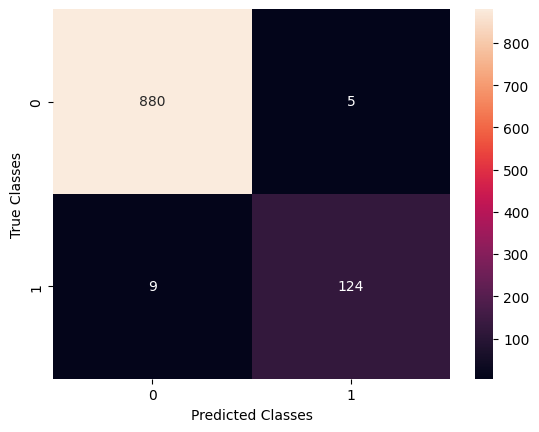

In [171]:
from sklearn.naive_bayes import MultinomialNB

naive_bayes_classifier = MultinomialNB()

naive_bayes_classifier.fit(X_train, y_train)

predictions = naive_bayes_classifier.predict(X_test)

print(classification_report(y_test, predictions))

sns.heatmap(confusion_matrix(y_test, predictions), annot = True, fmt = "d")
plt.xlabel("Predicted Classes")
plt.ylabel("True Classes")
plt.show()

# TF-IDF

In [172]:
tf_idf_vectorizer = TfidfVectorizer(max_features = 5000, ngram_range = (1, 3))

X = tf_idf_vectorizer.fit_transform(list(df["preprocessed_message"])).toarray()

y = df["label"].values

In [173]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

              precision    recall  f1-score   support

           0       0.97      1.00      0.99       885
           1       1.00      0.82      0.90       133

    accuracy                           0.98      1018
   macro avg       0.99      0.91      0.94      1018
weighted avg       0.98      0.98      0.98      1018



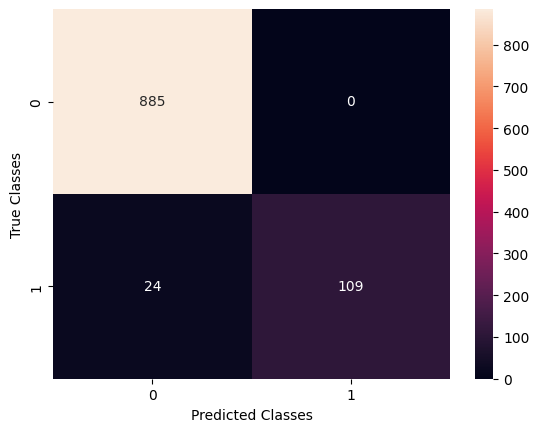

In [174]:
naive_bayes_classifier = MultinomialNB()

naive_bayes_classifier.fit(X_train, y_train)

predictions = naive_bayes_classifier.predict(X_test)

print(classification_report(y_test, predictions))

sns.heatmap(confusion_matrix(y_test, predictions), annot = True, fmt = "d")
plt.xlabel("Predicted Classes")
plt.ylabel("True Classes")
plt.show()

# Word2Vec


In [175]:
tokenized_sentences = [word_tokenize(sentence) for sentence in list(df["preprocessed_message"])]

In [176]:
tokenized_sentences[3]

['u', 'dun', 'say', 'early', 'hor', 'u', 'c', 'already', 'say']

In [177]:
model = Word2Vec(sentences = tokenized_sentences, window = 5, min_count = 1)

In [178]:
model.build_vocab(tokenized_sentences)

In [179]:
model.train(tokenized_sentences, total_examples = model.corpus_count, epochs = model.epochs)

(224894, 243350)

In [180]:
f"Our vocabulary has {len(model.wv.index_to_key)} unique elements"

'Our vocabulary has 8041 unique elements'

In [181]:
model.wv.most_similar("free")

[('nokia', 0.9997586011886597),
 ('claim', 0.9997364282608032),
 ('call', 0.999716579914093),
 ('tone', 0.9997152090072632),
 ('latest', 0.9997027516365051),
 ('reply', 0.9996999502182007),
 ('txt', 0.9996952414512634),
 ('min', 0.9996806979179382),
 ('phone', 0.9996801018714905),
 ('100', 0.999674379825592)]

In [182]:
model.wv["prize"]

array([-0.36580428,  0.6335047 ,  0.12424543,  0.00707956,  0.09311942,
       -1.1759018 ,  0.11756472,  1.3148075 , -0.5997533 , -0.3690319 ,
       -0.24276465, -0.8217858 , -0.34456402,  0.29366398,  0.15255271,
       -0.35137075,  0.29222834, -0.8045851 , -0.02279976, -1.2017587 ,
        0.37601098,  0.3491304 ,  0.63024414, -0.25638908,  0.06288105,
        0.16008808, -0.62580645, -0.4000592 , -0.58875287,  0.06558687,
        0.6055806 ,  0.04598231,  0.34316456, -0.495738  , -0.28224275,
        0.7379271 ,  0.01510744, -0.34935182, -0.49461412, -1.140214  ,
        0.14754571, -0.47788277, -0.1418007 , -0.1154754 ,  0.65591   ,
       -0.39894584, -0.30942684, -0.01508329,  0.43808052,  0.22263499,
        0.3128155 , -0.6034301 , -0.3257202 , -0.15188956, -0.37734315,
        0.42534235,  0.4179779 , -0.05312321, -0.49489358,  0.14921036,
        0.16331539,  0.16870655, -0.15638372,  0.16291067, -0.698096  ,
        0.5292605 ,  0.3168188 ,  0.6139076 , -0.72550595,  0.80

In [183]:
def average_word2vec(doc):
    return np.mean([model.wv[word] for word in doc if word in model.wv.index_to_key], axis = 0)

In [184]:
X = []

for sentence in tokenized_sentences:
    X.append(average_word2vec(sentence))

In [185]:
for array in X:
    if len(array.shape) == 0:
        print(array.shape)

In [186]:
X = np.array(X)

In [187]:
y = df["label"].values

In [188]:
X.shape, y.shape

((5087, 100), (5087,))

In [189]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [190]:
pd.Series(y_train).value_counts()

0    3549
1     520
Name: count, dtype: int64

In [191]:
ros = RandomOverSampler()

X_train, y_train = ros.fit_resample(X_train, y_train)

In [192]:
pd.Series(y_train).value_counts()

0    3549
1    3549
Name: count, dtype: int64

# Naive Bayes

              precision    recall  f1-score   support

           0       0.95      0.69      0.80       885
           1       0.27      0.77      0.40       133

    accuracy                           0.70      1018
   macro avg       0.61      0.73      0.60      1018
weighted avg       0.86      0.70      0.75      1018



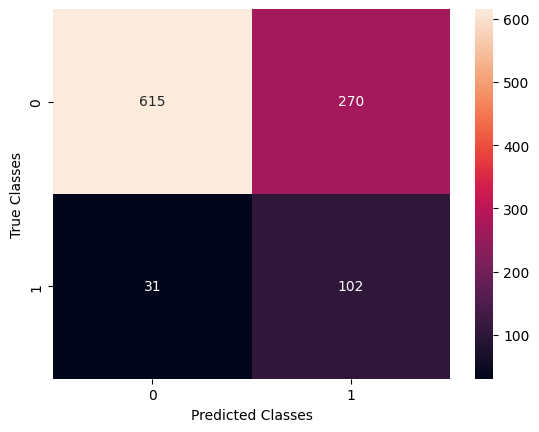

In [193]:
from sklearn.naive_bayes import MultinomialNB

ham_vs_spam_classifier = Pipeline([("scaler", MinMaxScaler()), ("classifier", MultinomialNB())])

ham_vs_spam_classifier.fit(X_train, y_train)

predictions = ham_vs_spam_classifier.predict(X_test)

print(classification_report(y_test, predictions))

sns.heatmap(confusion_matrix(y_test, predictions), annot = True, fmt = "d")
plt.xlabel("Predicted Classes")
plt.ylabel("True Classes")
plt.show()

# Logistic Regression


              precision    recall  f1-score   support

           0       0.98      0.90      0.94       885
           1       0.57      0.85      0.68       133

    accuracy                           0.90      1018
   macro avg       0.77      0.88      0.81      1018
weighted avg       0.92      0.90      0.90      1018



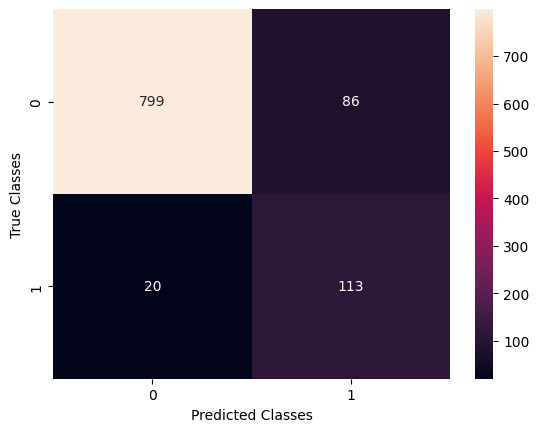

In [194]:
from sklearn.linear_model import LogisticRegression

ham_vs_spam_classifier1 = Pipeline([("scaler", MinMaxScaler()), ("classifier", LogisticRegression())])

ham_vs_spam_classifier1.fit(X_train, y_train)

predictions = ham_vs_spam_classifier1.predict(X_test)

print(classification_report(y_test, predictions))

sns.heatmap(confusion_matrix(y_test, predictions), annot = True, fmt = "d")
plt.xlabel("Predicted Classes")
plt.ylabel("True Classes")
plt.show()

# Decision Tree Classifier

              precision    recall  f1-score   support

           0       0.96      0.95      0.95       885
           1       0.68      0.74      0.71       133

    accuracy                           0.92      1018
   macro avg       0.82      0.84      0.83      1018
weighted avg       0.92      0.92      0.92      1018



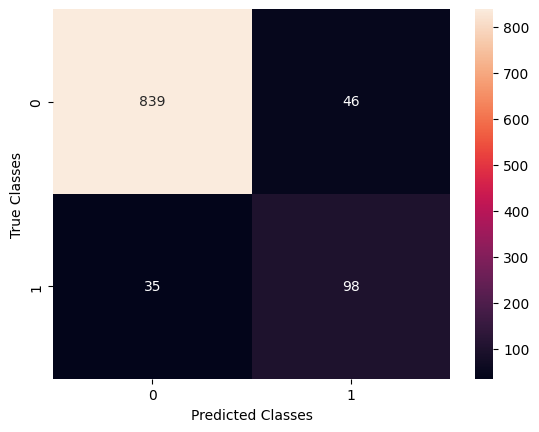

In [195]:
from sklearn.tree import DecisionTreeClassifier

ham_vs_spam_classifier2 = Pipeline([("scaler", MinMaxScaler()), ("classifier", DecisionTreeClassifier())])

ham_vs_spam_classifier2.fit(X_train, y_train)

predictions = ham_vs_spam_classifier2.predict(X_test)

print(classification_report(y_test, predictions))

sns.heatmap(confusion_matrix(y_test, predictions), annot = True, fmt = "d")
plt.xlabel("Predicted Classes")
plt.ylabel("True Classes")
plt.show()

# Random Forest Classifier

              precision    recall  f1-score   support

           0       0.96      0.99      0.98       885
           1       0.89      0.76      0.82       133

    accuracy                           0.96      1018
   macro avg       0.93      0.87      0.90      1018
weighted avg       0.96      0.96      0.96      1018



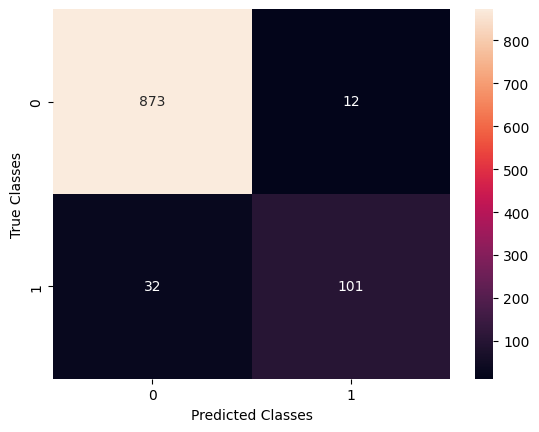

In [196]:
from sklearn.ensemble import RandomForestClassifier

ham_vs_spam_classifier3 = Pipeline([("scaler", MinMaxScaler()), ("classifier", RandomForestClassifier())])

ham_vs_spam_classifier3.fit(X_train, y_train)

predictions = ham_vs_spam_classifier3.predict(X_test)

print(classification_report(y_test, predictions))

sns.heatmap(confusion_matrix(y_test, predictions), annot = True, fmt = "d")
plt.xlabel("Predicted Classes")
plt.ylabel("True Classes")
plt.show()

In [197]:
def predict(text):
    cleaned_text = clean_text(text)
    preprocessed_text = preprocess_text(cleaned_text)
    tokenized_text = word_tokenize(preprocessed_text)
    mean_vector = average_word2vec(tokenized_text)
    if np.isnan(mean_vector).any():
        return "The message is spam"
    prediction = ham_vs_spam_classifier.predict([mean_vector])
    if prediction == 0:
        return "The message is ham"
    else:
        return "The message is spam"

In [230]:
print(predict("my name is raza jaun"))

The message is ham


In [199]:
os.makedirs("./model")
model.save("./model/hamvsspamword2vec.model")

In [200]:
joblib.dump(ham_vs_spam_classifier, "./model/hamvsspamclassifier.pkl")

['./model/hamvsspamclassifier.pkl']